# Hudson Valley Gentrification and Changes in Farming

## Notebook 2: ACS and Agriculture Census

In [1]:
import geopandas as gpd
import pandas as pd
import contextily as cx
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shapely
import numpy as np
from censusdis import data as ced
#from censusdis.datasets import ACS5
from census import Census

In [2]:
api_key_stadia = os.getenv("STADIA_API_KEY")
api_key_census = os.getenv("CENSUS_API_KEY")
api_key_nass = os.getenv("QUICK_STATS_API_KEY")

In [3]:
proj_nys_east = 26918
proj_hudson_ft = 32118
proj_nyc_ft = 2263
proj_ea = 6933
proj_latlon = 4326

In [4]:
def meters_to_miles(meters):
    return meters/1609
def miles_to_meters(miles):
    return miles*1609

## Import farms and tracts

In [5]:
gdf_farms_all = gpd.read_file("data/farms_core.geojson")

In [6]:
gdf_nys_tracts_2022 = gpd.read_file("data/tl_2022_36_tract.zip") # https://www2.census.gov/geo/tiger/TIGER2022/TRACT/tl_2022_36_tract.zip
gdf_nys_tracts_2017 = gpd.read_file("data/tl_2017_36_tract.zip") # https://www2.census.gov/geo/tiger/TIGER2017/TRACT/tl_2017_36_tract.zip

In [7]:
gdf_nys_counties = gpd.read_file("data/NYS_Civil_Boundaries_2455759864913236436.geojson")

In [8]:
gdf_farms = gdf_farms_all.query("moran == True").copy()

## Select tracts of interest

Identify tracts that fall partially or entirely within ten miles of any farm in the "core" cluster of market farms.

In [9]:
gdf_farms = gdf_farms.to_crs(proj_nys_east)

In [10]:
gdf_nys_tracts_2022 = gdf_nys_tracts_2022.to_crs(proj_nys_east)
gdf_nys_tracts_2017 = gdf_nys_tracts_2017.to_crs(proj_nys_east)

In [11]:
gdf_nys_counties = gdf_nys_counties.to_crs(proj_nys_east)

In [12]:
gdf_farms["buffer_10mi"] = gdf_farms.buffer(miles_to_meters(10)).geometry

<Axes: >

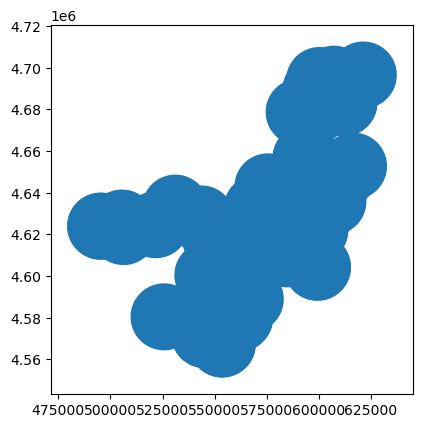

In [13]:
gdf_farms["buffer_10mi"].plot()

<Axes: >

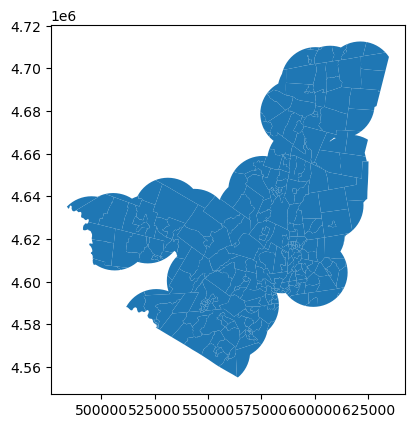

In [14]:
gdf_nys_tracts_2022.clip(gdf_farms["buffer_10mi"]).plot()

<Axes: >

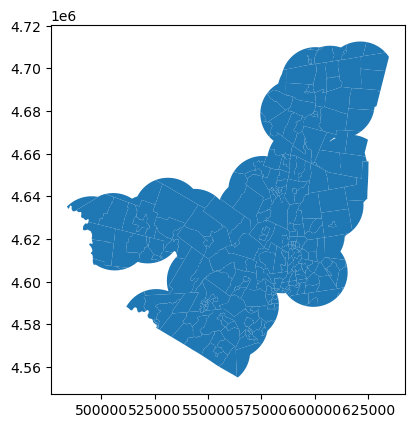

In [15]:
gdf_nys_tracts_2017.clip(gdf_farms["buffer_10mi"]).plot()

In [16]:
gdf_tracts_core_2022 = gdf_nys_tracts_2022[gdf_nys_tracts_2022.index.isin(gdf_nys_tracts_2022.sjoin(gdf_nys_tracts_2022.clip(gdf_farms["buffer_10mi"]), how="inner", predicate="intersects").index)].copy()

In [17]:
gdf_tracts_core_2017 = gdf_nys_tracts_2017[gdf_nys_tracts_2017.index.isin(gdf_nys_tracts_2017.sjoin(gdf_nys_tracts_2017.clip(gdf_farms["buffer_10mi"]), how="inner", predicate="intersects").index)].copy()

<Axes: >

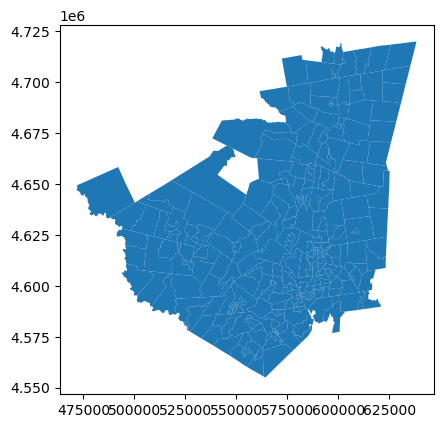

In [18]:
gdf_tracts_core_2022.plot()

<Axes: >

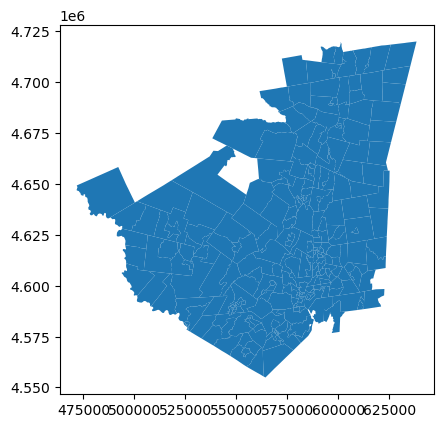

In [19]:
gdf_tracts_core_2017.plot()

In [20]:
gdf_tracts_core_2022.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
104,36,105,951701,36105951701,9517.01,Census Tract 9517.01,G5020,S,80751463,4230629,+41.6252683,-074.6109770,"POLYGON ((527485.433 4611964.593, 527486.865 4..."
105,36,105,951801,36105951801,9518.01,Census Tract 9518.01,G5020,S,9416768,161484,+41.6353707,-074.6665861,"POLYGON ((524469.064 4612440.958, 524508.046 4..."
106,36,105,951302,36105951302,9513.02,Census Tract 9513.02,G5020,S,79633377,998387,+41.6346723,-074.4914470,"POLYGON ((536422.502 4606104.963, 536528.422 4..."
107,36,105,951802,36105951802,9518.02,Census Tract 9518.02,G5020,S,3677536,74552,+41.6500499,-074.7108274,"POLYGON ((523228.27 4610556.874, 523249.305 46..."
108,36,105,950801,36105950801,9508.01,Census Tract 9508.01,G5020,S,35408221,1338257,+41.7864811,-074.6607209,"POLYGON ((524576.278 4626499.536, 524679.494 4..."


In [21]:
gdf_tracts_core_2017 = gdf_tracts_core_2017.assign(COUNTYFIPS = lambda df: df.STATEFP + df.COUNTYFP)

In [22]:
gdf_tracts_core_2022 = gdf_tracts_core_2022.assign(COUNTYFIPS = lambda df: df.STATEFP + df.COUNTYFP)
gdf_tracts_core_2022.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,COUNTYFIPS
104,36,105,951701,36105951701,9517.01,Census Tract 9517.01,G5020,S,80751463,4230629,+41.6252683,-074.6109770,"POLYGON ((527485.433 4611964.593, 527486.865 4...",36105
105,36,105,951801,36105951801,9518.01,Census Tract 9518.01,G5020,S,9416768,161484,+41.6353707,-074.6665861,"POLYGON ((524469.064 4612440.958, 524508.046 4...",36105
106,36,105,951302,36105951302,9513.02,Census Tract 9513.02,G5020,S,79633377,998387,+41.6346723,-074.4914470,"POLYGON ((536422.502 4606104.963, 536528.422 4...",36105
107,36,105,951802,36105951802,9518.02,Census Tract 9518.02,G5020,S,3677536,74552,+41.6500499,-074.7108274,"POLYGON ((523228.27 4610556.874, 523249.305 46...",36105
108,36,105,950801,36105950801,9508.01,Census Tract 9508.01,G5020,S,35408221,1338257,+41.7864811,-074.6607209,"POLYGON ((524576.278 4626499.536, 524679.494 4...",36105


In [23]:
gdf_counties_core = gdf_nys_counties.query("FIPS_CODE in @gdf_tracts_core_2022.COUNTYFIPS").copy()
gdf_counties_core

,OBJECTID,NAME,ABBREV,GNIS_ID,FIPS_CODE,SWIS,NYSP_ZONE,POP1990,POP2000,POP2010,POP2020,DOS_LL,DOSLL_DATE,NYC,CALC_SQ_MI,DATEMOD,geometry
0,1,Albany,ALBA,974099,36001,010000,East,292594,294565,304204,314848,None,None,N,532.791779,"Fri, 10 Nov 2017 00:00:00 GMT","POLYGON ((608218.927 4737613.315, 608193.336 4..."
10,11,Columbia,COLU,974109,36021,100000,East,62982,63094,63096,61570,None,None,N,647.905835,"Mon, 22 Jan 2018 00:00:00 GMT","POLYGON ((624387.318 4656389.284, 624387.085 4..."
12,13,Delaware,DELA,974111,36025,120000,East,47225,48055,47980,44308,None,None,N,1466.338072,"Tue, 19 May 2020 00:00:00 GMT","POLYGON ((523750.277 4707243.712, 523816.31 47..."
13,14,Dutchess,DUTC,974112,36027,130000,East,259462,280150,297488,295911,None,None,N,824.438109,"Thu, 08 Nov 2018 00:00:00 GMT","POLYGON ((624387.318 4656389.284, 624388.346 4..."
19,20,Greene,GREE,974118,36039,190000,East,44739,48195,49221,47931,None,None,N,657.720079,"Tue, 19 May 2020 00:00:00 GMT","POLYGON ((590039.896 4664494.401, 589739.777 4..."
35,36,Orange,ORAN,974134,36071,330000,East,307647,341367,372813,401310,None,None,N,837.148961,"Fri, 15 May 2020 00:00:00 GMT","POLYGON ((587211.589 4604774.186, 587211.21 46..."
39,40,Putnam,PUTN,974138,36079,370000,East,83941,95745,99710,97668,None,None,N,245.989024,"Thu, 08 Nov 2018 00:00:00 GMT","POLYGON ((622581.399 4598234.108, 622573.885 4..."
41,42,Rensselaer,RENS,974140,36083,380000,East,154429,152538,159429,161130,None,None,N,665.084035,"Fri, 10 Nov 2017 00:00:00 GMT","POLYGON ((640790.386 4756004.259, 640790.377 4..."
52,53,Sullivan,SULL,974150,36105,480000,East,69277,73966,77547,78624,None,None,N,995.439165,"Fri, 15 May 2020 00:00:00 GMT","POLYGON ((552753.314 4604558.944, 552710.697 4..."
55,56,Ulster,ULST,974153,36111,510000,East,165304,177749,182493,181851,None,None,N,1161.254720,"Wed, 25 Oct 2017 00:00:00 GMT","POLYGON ((590039.896 4664494.401, 589947.276 4..."


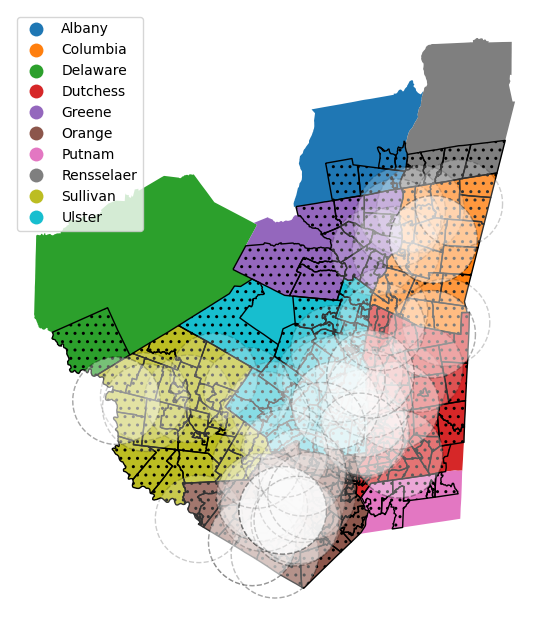

In [24]:
ax = gdf_counties_core.plot(column="NAME", figsize=(8,8), legend=True, legend_kwds={"loc": "upper left"})
gdf_tracts_core_2022.plot(ax=ax, facecolor="none", edgecolor="black", hatch="..")
gdf_farms["buffer_10mi"].plot(ax=ax, facecolor="white", alpha=0.2, edgecolor="black", linestyle="--")
ax.axis("off");

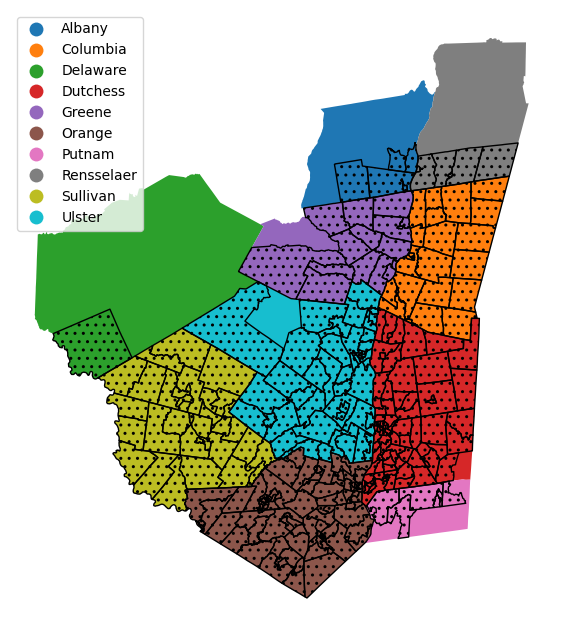

In [25]:
ax = gdf_counties_core.to_crs(proj_hudson_ft).plot(column="NAME", figsize=(8,8), legend=True, legend_kwds={"loc": "upper left"})
gdf_tracts_core_2022.to_crs(proj_hudson_ft).plot(ax=ax, facecolor="none", edgecolor="black", hatch="..")
ax.axis("off");

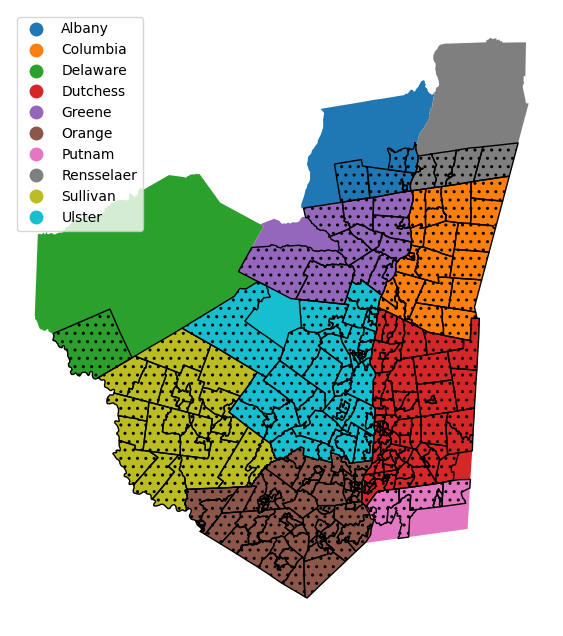

In [26]:
ax = gdf_counties_core.to_crs(proj_hudson_ft).plot(column="NAME", figsize=(8,8), legend=True, legend_kwds={"loc": "upper left"})
gdf_tracts_core_2017.to_crs(proj_hudson_ft).plot(ax=ax, facecolor="none", edgecolor="black", hatch="..")
ax.axis("off");

## Get ACS data

### Choose and refine variables

In [27]:
acs_years = ["2017", "2022"]

In [28]:
acs_var_groups = ["B25003","B25038","B25039",'B25057','B25058','B25059','B25071','B19013','B01003']

In [29]:
c = Census(api_key_census)

In [30]:
acs5tables = pd.DataFrame.from_dict(c.acs5.tables())
acs5tables

,name,description,variables,universe
0,B18104,Sex by Age by Cognitive Difficulty,http://api.census.gov/data/2023/acs/acs5/group...,Civilian noninstitutionalized population 5 yea...
1,B17015,Poverty Status in the Past 12 Months of Famili...,http://api.census.gov/data/2023/acs/acs5/group...,Families
2,B18105,Sex by Age by Ambulatory Difficulty,http://api.census.gov/data/2023/acs/acs5/group...,Civilian noninstitutionalized population 5 yea...
3,B17016,Poverty Status in the Past 12 Months of Famili...,http://api.census.gov/data/2023/acs/acs5/group...,Families
4,B18106,Sex by Age by Self-Care Difficulty,http://api.census.gov/data/2023/acs/acs5/group...,Civilian noninstitutionalized population 5 yea...
...,...,...,...,...
1188,B99131,Allocation of Marital Status for Females 15 to...,http://api.census.gov/data/2023/acs/acs5/group...,Women 15 to 50 years
1189,B09018,Relationship to Householder for Children Under...,http://api.census.gov/data/2023/acs/acs5/group...,Population under 18 years in households (exclu...
1190,B99132,Allocation of Fertility of Women 15 to 50 Years,http://api.census.gov/data/2023/acs/acs5/group...,Women 15 to 50 years
1191,B09019,Household Type (Including Living Alone) by Rel...,http://api.census.gov/data/2023/acs/acs5/group...,Total population


In [31]:
acs5tables = acs5tables.rename(columns={"universe ": "universe"})

In [32]:
acs5vars = acs5tables.query("name in @acs_var_groups")
acs5vars

,name,description,variables,universe
231,B25039,Median Year Householder Moved Into Unit by Tenure,http://api.census.gov/data/2023/acs/acs5/group...,Occupied housing units
232,B25038,Tenure by Year Householder Moved Into Unit,http://api.census.gov/data/2023/acs/acs5/group...,Occupied housing units
320,B25003,Tenure,http://api.census.gov/data/2023/acs/acs5/group...,Occupied housing units
344,B25071,Median Gross Rent as a Percentage of Household...,http://api.census.gov/data/2023/acs/acs5/group...,Renter-occupied housing units paying cash rent
400,B25057,Lower Contract Rent Quartile (Dollars),http://api.census.gov/data/2023/acs/acs5/group...,Renter-occupied housing units paying cash rent
402,B25059,Upper Contract Rent Quartile (Dollars),http://api.census.gov/data/2023/acs/acs5/group...,Renter-occupied housing units paying cash rent
403,B25058,Median Contract Rent (Dollars),http://api.census.gov/data/2023/acs/acs5/group...,Renter-occupied housing units paying cash rent
503,B01003,Total Population,http://api.census.gov/data/2023/acs/acs5/group...,Total population
1081,B19013,Median Household Income in the Past 12 Months ...,http://api.census.gov/data/2023/acs/acs5/group...,Households


In [34]:
ced.variables.get_group(dataset="acs/acs5", year=2022, name="B25003")

{'NAME': {'label': 'Geographic Area Name',
  'concept': "Sex by Occupation for the Full-Time, Year-Round Civilian Employed Population 16 Years and Over;Sex by Industry for the Civilian Employed Population 16 Years and Over;Sex by Industry for the Full-Time, Year-Round Civilian Employed Population 16 Years and Over;Industry by Occupation for the Civilian Employed Population 16 Years and Over;Occupation by Class of Worker for the Civilian Employed Population 16 Years and Over;Industry by Class of Worker for the Civilian Employed Population 16 Years and Over;Health Insurance Coverage Status by Age (White Alone);Health Insurance Coverage Status by Age (Black or African American Alone);Health Insurance Coverage Status by Age (American Indian and Alaska Native Alone);Health Insurance Coverage Status by Age (Asian Alone);Health Insurance Coverage Status by Age (Native Hawaiian and Other Pacific Islander Alone);Health Insurance Coverage Status by Age (Some Other Race Alone);Health Insurance Co

In [85]:
acsvar_dict = {}
for year in acs_years:
    acsvar_dict[year] = {}
    for acsvar in acs_var_groups:
        universe = acs5tables.query("name == @acsvar")["universe"].values[0]
        description = acs5tables.query("name == @acsvar").description.values[0]
        acsvar_dict[year][acsvar] = {"universe": universe,
                            "description": description,
                            "variables": []}
    #    print(acs5tables.query(f"name == @acsvar")["universe"].values[0], "-", acs5tables.query("name == @acsvar").description.values[0])
        varget = ced.variables.get_group(dataset="acs/acs5", year=int(year), name=acsvar)
        for var in varget:
            if var[-1] == 'E' and var != 'NAME':
    #            print(varget[var]['name'], varget[var]['label'], f"({varget[var]['predicateType']})")
                acsvar_dict[year][acsvar]['variables'].append({'variable': varget[var]['name'],
                                                        'label': varget[var]['label'],
                                                        'type': varget[var]['predicateType']})
acsvar_dict

{'2017': {'B25003': {'universe': 'Occupied housing units',
   'description': 'Tenure',
   'variables': [{'variable': 'B25003_003E',
     'label': 'Estimate!!Total!!Renter occupied',
     'type': 'int'},
    {'variable': 'B25003_002E',
     'label': 'Estimate!!Total!!Owner occupied',
     'type': 'int'},
    {'variable': 'B25003_001E', 'label': 'Estimate!!Total', 'type': 'int'}]},
  'B25038': {'universe': 'Occupied housing units',
   'description': 'Tenure by Year Householder Moved Into Unit',
   'variables': [{'variable': 'B25038_011E',
     'label': 'Estimate!!Total!!Renter occupied!!Moved in 2010 to 2014',
     'type': 'int'},
    {'variable': 'B25038_010E',
     'label': 'Estimate!!Total!!Renter occupied!!Moved in 2015 or later',
     'type': 'int'},
    {'variable': 'B25038_015E',
     'label': 'Estimate!!Total!!Renter occupied!!Moved in 1979 or earlier',
     'type': 'int'},
    {'variable': 'B25038_014E',
     'label': 'Estimate!!Total!!Renter occupied!!Moved in 1980 to 1989',
  

In [54]:
acs5_fields = ['NAME']
for year in acs_years:
    for var in acsvar_dict[year]:
        for var2 in acsvar_dict[year][var]['variables']:
            if year == '2017':
                acs5_fields.append(var2['variable'])
            else:
                pass
acs5_fields

['NAME',
 'B25003_003E',
 'B25003_002E',
 'B25003_001E',
 'B25038_011E',
 'B25038_010E',
 'B25038_015E',
 'B25038_014E',
 'B25038_013E',
 'B25038_012E',
 'B25038_003E',
 'B25038_002E',
 'B25038_001E',
 'B25038_008E',
 'B25038_007E',
 'B25038_006E',
 'B25038_005E',
 'B25038_004E',
 'B25038_009E',
 'B25039_002E',
 'B25039_001E',
 'B25039_003E',
 'B25057_001E',
 'B25058_001E',
 'B25059_001E',
 'B25071_001E',
 'B19013_001E',
 'B01003_001E']

In [55]:
county_fips = list(gdf_tracts_core_2022.COUNTYFP.unique())

In [56]:
tract_fips_2017 = list(gdf_tracts_core_2017.TRACTCE)
tract_fips_2022 = list(gdf_tracts_core_2022.TRACTCE)

In [57]:
gdf_tracts_core_2017.head(1)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,COUNTYFIPS
292,36,105,950800,36105950800,9508,Census Tract 9508,G5020,S,83049493,1537088,+41.7707267,-074.6178671,"POLYGON ((524576.278 4626499.536, 524679.494 4...",36105


### Get ACS data

In [58]:
acs_tracts_data = []
for year in acs_years:
    data = ced.download(
        dataset='acs/acs5',
        vintage=int(year),
        download_variables=acs5_fields,
        api_key=api_key_census,
        state='36',
        county=county_fips,
        tract='*'
    )
    acs_tracts_data.append(data)

In [59]:
acs_tracts_data[0].head()

,STATE,COUNTY,TRACT,NAME,B25003_003E,B25003_002E,B25003_001E,B25038_011E,B25038_010E,B25038_015E,...,B25038_009E,B25039_002E,B25039_001E,B25039_003E,B25057_001E,B25058_001E,B25059_001E,B25071_001E,B19013_001E,B01003_001E
0,36,111,950600,"Census Tract 9506, Ulster County, New York",235,1144,1379,107,43,0,...,235,1996.0,1999.0,2012.0,823.0,942.0,994.0,45.3,83107.0,2643
1,36,111,951100,"Census Tract 9511, Ulster County, New York",145,977,1122,110,0,6,...,145,1998.0,2001.0,2012.0,906.0,985.0,1112.0,50.0,72031.0,2361
2,36,111,951800,"Census Tract 9518, Ulster County, New York",372,349,721,172,26,5,...,372,2000.0,2006.0,2010.0,480.0,683.0,975.0,33.0,35759.0,1680
3,36,111,953000,"Census Tract 9530, Ulster County, New York",186,557,743,68,41,6,...,186,2002.0,2004.0,2011.0,667.0,735.0,894.0,42.6,66726.0,1907
4,36,111,954900,"Census Tract 9549, Ulster County, New York",163,407,570,139,5,0,...,163,1993.0,1999.0,NaN,862.0,1044.0,1207.0,50.0,61500.0,1368


In [69]:
acs_tracts_data[0].query('TRACT in @gdf_tracts_core_2017.TRACTCE').info()

<class 'pandas.core.frame.DataFrame'>
Index: 314 entries, 0 to 414
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   STATE        314 non-null    object 
 1   COUNTY       314 non-null    object 
 2   TRACT        314 non-null    object 
 3   NAME         314 non-null    object 
 4   B25003_003E  314 non-null    int64  
 5   B25003_002E  314 non-null    int64  
 6   B25003_001E  314 non-null    int64  
 7   B25038_011E  314 non-null    int64  
 8   B25038_010E  314 non-null    int64  
 9   B25038_015E  314 non-null    int64  
 10  B25038_014E  314 non-null    int64  
 11  B25038_013E  314 non-null    int64  
 12  B25038_012E  314 non-null    int64  
 13  B25038_003E  314 non-null    int64  
 14  B25038_002E  314 non-null    int64  
 15  B25038_001E  314 non-null    int64  
 16  B25038_008E  314 non-null    int64  
 17  B25038_007E  314 non-null    int64  
 18  B25038_006E  314 non-null    int64  
 19  B25038_005E  

In [70]:
acs_tracts_data[1].query('TRACT in @gdf_tracts_core_2022.TRACTCE').info()

<class 'pandas.core.frame.DataFrame'>
Index: 343 entries, 0 to 468
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   STATE        343 non-null    object 
 1   COUNTY       343 non-null    object 
 2   TRACT        343 non-null    object 
 3   NAME         343 non-null    object 
 4   B25003_003E  343 non-null    int64  
 5   B25003_002E  343 non-null    int64  
 6   B25003_001E  343 non-null    int64  
 7   B25038_011E  343 non-null    int64  
 8   B25038_010E  343 non-null    int64  
 9   B25038_015E  343 non-null    int64  
 10  B25038_014E  343 non-null    int64  
 11  B25038_013E  343 non-null    int64  
 12  B25038_012E  343 non-null    int64  
 13  B25038_003E  343 non-null    int64  
 14  B25038_002E  343 non-null    int64  
 15  B25038_001E  343 non-null    int64  
 16  B25038_008E  343 non-null    int64  
 17  B25038_007E  343 non-null    int64  
 18  B25038_006E  343 non-null    int64  
 19  B25038_005E  

In [94]:
for year in acs_years:
    for vargroup in acs_var_groups:
        num = acs_years.index(year)
        data_df = acs_tracts_data[num].query(f'TRACT in @gdf_tracts_core_{year}.TRACTCE')
        for var in acsvar_dict[year][vargroup]['variables']:
            columns = ['STATE','COUNTY','TRACT','NAME'] + [var['variable']]
            var['data'] = data_df[columns].copy()
acsvar_dict

{'2017': {'B25003': {'universe': 'Occupied housing units',
   'description': 'Tenure',
   'variables': [{'variable': 'B25003_003E',
     'label': 'Estimate!!Total!!Renter occupied',
     'type': 'int',
     'data':     STATE COUNTY   TRACT                                          NAME  \
     0      36    111  950600    Census Tract 9506, Ulster County, New York   
     1      36    111  951100    Census Tract 9511, Ulster County, New York   
     2      36    111  951800    Census Tract 9518, Ulster County, New York   
     3      36    111  953000    Census Tract 9530, Ulster County, New York   
     4      36    111  954900    Census Tract 9549, Ulster County, New York   
     ..    ...    ...     ...                                           ...   
     406    36    001  000700       Census Tract 7, Albany County, New York   
     409    36    001  012700     Census Tract 127, Albany County, New York   
     410    36    001  012900     Census Tract 129, Albany County, New York   


In [96]:
acs5vars

,name,description,variables,universe
231,B25039,Median Year Householder Moved Into Unit by Tenure,http://api.census.gov/data/2023/acs/acs5/group...,Occupied housing units
232,B25038,Tenure by Year Householder Moved Into Unit,http://api.census.gov/data/2023/acs/acs5/group...,Occupied housing units
320,B25003,Tenure,http://api.census.gov/data/2023/acs/acs5/group...,Occupied housing units
344,B25071,Median Gross Rent as a Percentage of Household...,http://api.census.gov/data/2023/acs/acs5/group...,Renter-occupied housing units paying cash rent
400,B25057,Lower Contract Rent Quartile (Dollars),http://api.census.gov/data/2023/acs/acs5/group...,Renter-occupied housing units paying cash rent
402,B25059,Upper Contract Rent Quartile (Dollars),http://api.census.gov/data/2023/acs/acs5/group...,Renter-occupied housing units paying cash rent
403,B25058,Median Contract Rent (Dollars),http://api.census.gov/data/2023/acs/acs5/group...,Renter-occupied housing units paying cash rent
503,B01003,Total Population,http://api.census.gov/data/2023/acs/acs5/group...,Total population
1081,B19013,Median Household Income in the Past 12 Months ...,http://api.census.gov/data/2023/acs/acs5/group...,Households


In [ ]:
acsvar_dict['2017']['B01003']['variables'][0]['data']

,STATE,COUNTY,TRACT,NAME,B01003_001E
0,36,111,950600,"Census Tract 9506, Ulster County, New York",2643
1,36,111,951100,"Census Tract 9511, Ulster County, New York",2361
2,36,111,951800,"Census Tract 9518, Ulster County, New York",1680
3,36,111,953000,"Census Tract 9530, Ulster County, New York",1907
4,36,111,954900,"Census Tract 9549, Ulster County, New York",1368
...,...,...,...,...,...
406,36,001,000700,"Census Tract 7, Albany County, New York",3711
409,36,001,012700,"Census Tract 127, Albany County, New York",2550
410,36,001,012900,"Census Tract 129, Albany County, New York",3439
413,36,001,014302,"Census Tract 143.02, Albany County, New York",8458


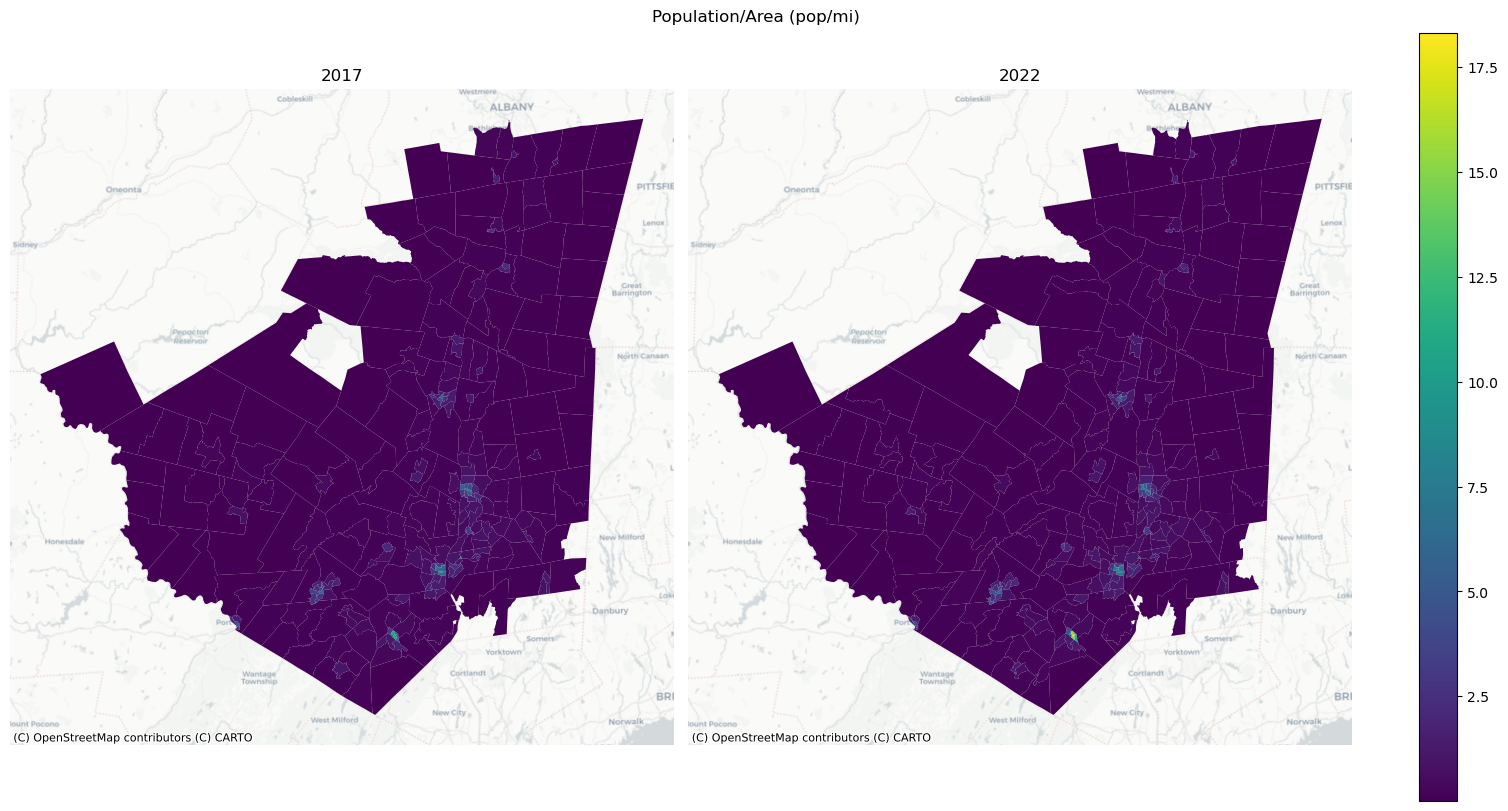

In [126]:
pop2017 = gdf_tracts_core_2017.merge(acsvar_dict['2017']['B01003']['variables'][0]['data'], how='left', left_on=['STATEFP','COUNTYFP','TRACTCE'], right_on=["STATE",'COUNTY','TRACT']).assign(pop_area = lambda df: df.B01003_001E/meters_to_miles(df.ALAND))
pop2022 = gdf_tracts_core_2022.merge(acsvar_dict['2022']['B01003']['variables'][0]['data'], how='left', left_on=['STATEFP','COUNTYFP','TRACTCE'], right_on=["STATE",'COUNTY','TRACT']).assign(pop_area = lambda df: df.B01003_001E/meters_to_miles(df.ALAND))
vmin = min([pop2017.pop_area.min(),pop2022.pop_area.min()])
vmax = max([pop2017.pop_area.max(),pop2022.pop_area.max()])

fig, axs = plt.subplots(1,2, constrained_layout=True, figsize=(15,8))
pop2017.plot(column='pop_area', ax=axs[0], vmin=vmin, vmax=vmax, cmap='viridis').set_axis_off()
pop2022.plot(column='pop_area', ax=axs[1], vmin=vmin, vmax=vmax, cmap='viridis').set_axis_off()

axs[0].set_title("2017")
axs[1].set_title("2022")

for ax in axs:
    cx.add_basemap(ax=ax, crs=pop2017.crs, source=cx.providers.CartoDB.Positron)

cbar = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='viridis')

fig.colorbar(cbar, ax=axs)
fig.suptitle("Population/Area (pop/mi)");

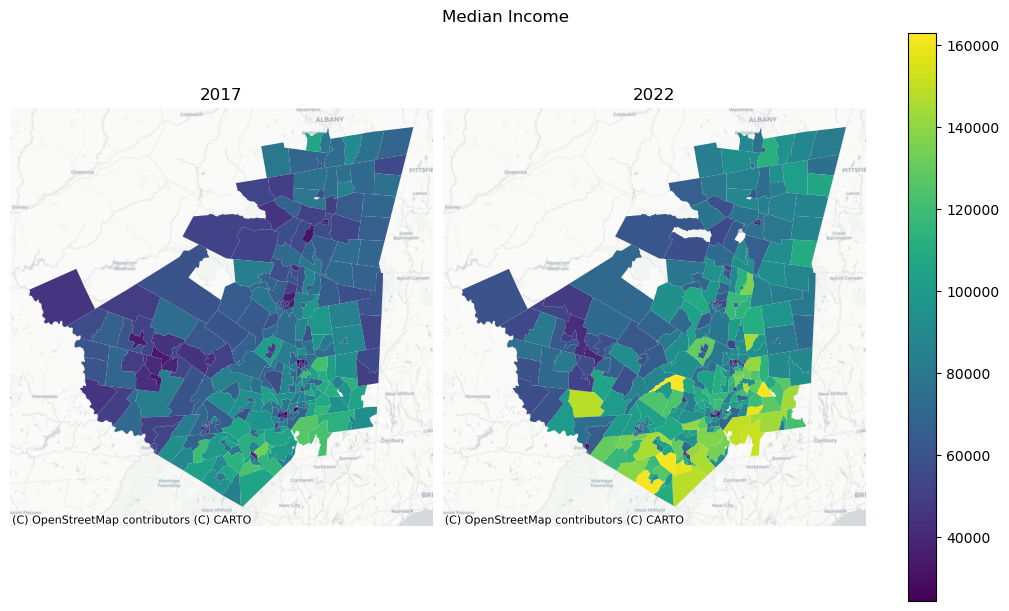

In [124]:
income2017 = gdf_tracts_core_2017.merge(acsvar_dict['2017']['B19013']['variables'][0]['data'], how='left', left_on=['STATEFP','COUNTYFP','TRACTCE'], right_on=["STATE",'COUNTY','TRACT'])
income2022 = gdf_tracts_core_2022.merge(acsvar_dict['2022']['B19013']['variables'][0]['data'], how='left', left_on=['STATEFP','COUNTYFP','TRACTCE'], right_on=["STATE",'COUNTY','TRACT'])
vmin = min([income2017.B19013_001E.min(),income2022.B19013_001E.min()])
vmax = max([income2017.B19013_001E.max(),income2022.B19013_001E.max()])

fig, axs = plt.subplots(1,2, constrained_layout=True, figsize=(10,6))
income2017.plot(column='B19013_001E', ax=axs[0], vmin=vmin, vmax=vmax, cmap='viridis').set_axis_off()
income2022.plot(column='B19013_001E', ax=axs[1], vmin=vmin, vmax=vmax, cmap='viridis').set_axis_off()

axs[0].set_title("2017")
axs[1].set_title("2022")

for ax in axs:
    cx.add_basemap(ax=ax, crs=income2017.crs, source=cx.providers.CartoDB.Positron)

cbar = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='viridis')

fig.colorbar(cbar, ax=axs)
fig.suptitle("Median Income");

### Combine ACS5 data with tract data

In [135]:
gdf_tracts_core_acsvars = []
for year in acs_years:
    df = eval(f"gdf_tracts_core_{year}").copy()
    for vargroup in acs_var_groups:
        for var in acsvar_dict[year][vargroup]['variables']:
            var_id = var['variable']
            var_df = var['data']
            df = df.merge(var_df.drop(['NAME'], axis=1), how='left', left_on=['STATEFP', 'COUNTYFP', 'TRACTCE'], right_on=['STATE','COUNTY','TRACT'])
            df.drop(['STATE','COUNTY','TRACT'], axis=1, inplace=True)
    gdf_tracts_core_acsvars.append(df.copy())

gdf_tracts_core_acsvars[0].head(1)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,B25038_009E,B25039_002E,B25039_001E,B25039_003E,B25057_001E,B25058_001E,B25059_001E,B25071_001E,B19013_001E,B01003_001E
0,36,105,950800,36105950800,9508,Census Tract 9508,G5020,S,83049493,1537088,...,301,2000.0,2003.0,2012.0,600.0,640.0,698.0,48.0,44795.0,4525


### Interpolate null values

Wherever possible, replace null values with the following year's value; then try the preceding year's value.

In [158]:
gdf_tracts_core_acsvars[0].tail()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,B25038_009E,B25039_002E,B25039_001E,B25039_003E,B25057_001E,B25058_001E,B25059_001E,B25071_001E,B19013_001E,B01003_001E
273,36,027,060302,36027060302,603.02,Census Tract 603.02,G5020,S,15728818,317610,...,193,2007.0,2008.0,2012.0,1152.0,2010.0,2422.0,25.8,103077.0,2602
274,36,027,060400,36027060400,604,Census Tract 604,G5020,S,2119351,11273,...,658,2001.0,2010.0,2013.0,1072.0,1409.0,1799.0,24.8,62917.0,2127
275,36,027,640002,36027640002,6400.02,Census Tract 6400.02,G5020,S,2304852,13876,...,58,NaN,2010.0,2010.0,779.0,1023.0,1137.0,50.0,24375.0,1467
276,36,027,130004,36027130004,1300.04,Census Tract 1300.04,G5020,S,24394742,363638,...,80,1996.0,1998.0,2012.0,823.0,1057.0,1616.0,50.0,96250.0,1601
277,36,027,050104,36027050104,501.04,Census Tract 501.04,G5020,S,25376694,233911,...,114,2003.0,2003.0,2012.0,836.0,871.0,NaN,13.1,110273.0,6824


In [179]:
null_vals_2017 = []
null_vals_2022 = []
for idx, row in gdf_tracts_core_acsvars[0].iterrows():
    for col in row.index:
        dp = row[col]
        if type(dp) == float and np.isnan(dp):
            null_vals_2017.append([idx, col])
for idx, row in gdf_tracts_core_acsvars[1].iterrows():
    for col in row.index:
        dp = row[col]
        if type(dp) == float and np.isnan(dp):
            null_vals_2022.append([idx, col])
print(len(null_vals_2017))
print(len(null_vals_2022))

49
81


In [205]:
null_vals_2017_new = []
null_vals_2022_new = []

for i, year in enumerate(acs_years):
    nulllist = eval(f'null_vals_{year}')
    newyear = int(year) + 1
    dataset = gdf_tracts_core_acsvars[i]
    for item in nulllist:
        var = item[1]
        idx = item[0]
        county=dataset.loc[idx,'COUNTYFP']
        tract=dataset.loc[idx,'TRACTCE']
        newval_df = ced.download(
            dataset='acs/acs5',
            vintage=newyear,
            download_variables=var,
            api_key=api_key_census,
            state='36',
            county=county,
            tract=tract
        )
        newval = newval_df.loc[0,var]
        if np.isnan(newval):
            eval(f'null_vals_{year}_new').append([idx, var])
        else:
            dataset.loc[idx,var] = newval

print(len(null_vals_2017_new))
print(len(null_vals_2022_new))        

35
53


In [206]:
null_vals_2017_new2 = []
null_vals_2022_new2 = []

for i, year in enumerate(acs_years):
    nulllist = eval(f'null_vals_{year}_new')
    newyear = int(year) - 1
    dataset = gdf_tracts_core_acsvars[i]
    for item in nulllist:
        var = item[1]
        idx = item[0]
        county=dataset.loc[idx,'COUNTYFP']
        tract=dataset.loc[idx,'TRACTCE']
        newval_df = ced.download(
            dataset='acs/acs5',
            vintage=newyear,
            download_variables=var,
            api_key=api_key_census,
            state='36',
            county=county,
            tract=tract
        )
        newval = newval_df.loc[0,var]
        if np.isnan(newval):
            eval(f'null_vals_{year}_new2').append([idx, var])
        else:
            dataset.loc[idx,var] = newval

print(len(null_vals_2017_new2))
print(len(null_vals_2022_new2))        

27
30


In [ ]:
# index of tracts still missing 2017 data
set([val[0] for val in null_vals_2017_new2])

{144, 145, 182, 192, 275, 277}

In [ ]:
# index of tracts still missing 2022 data
set([val[0] for val in null_vals_2022_new2])

{45, 135, 136, 152, 154, 176, 192, 225, 243, 251, 303}

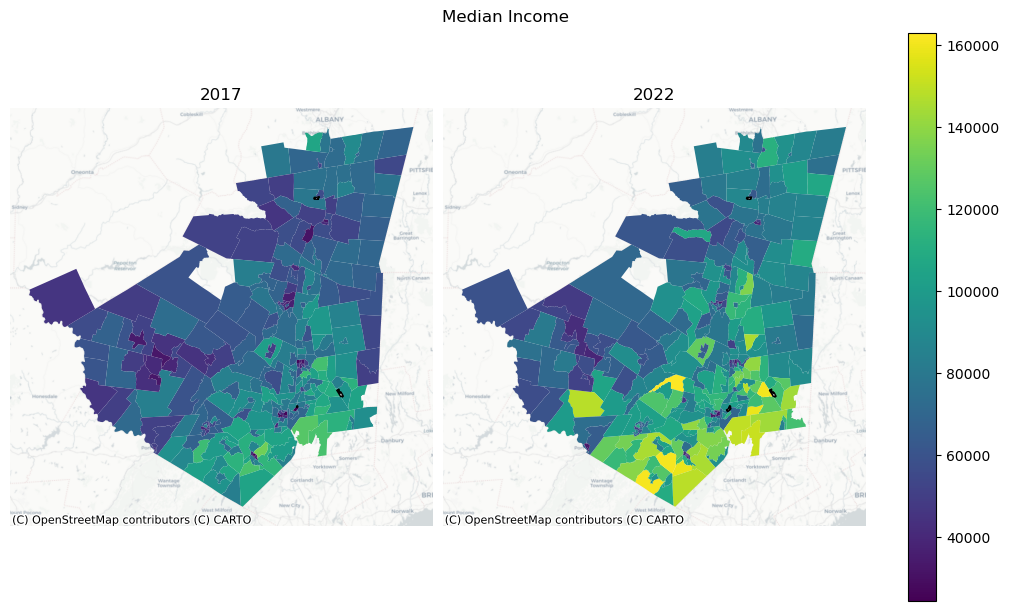

In [220]:
vmin = min([gdf_tracts_core_acsvars[0]['B19013_001E'].min(),gdf_tracts_core_acsvars[1]['B19013_001E'].min()])
vmax = max([gdf_tracts_core_acsvars[0]['B19013_001E'].max(),gdf_tracts_core_acsvars[1]['B19013_001E'].max()])
missing_kwds={
        "color": "lightgrey",
        "edgecolor": "black",
        "hatch": "////",
        "label": "Missing values",
    }

fig, axs = plt.subplots(1,2, constrained_layout=True, figsize=(10,6))
gdf_tracts_core_acsvars[0].plot(column='B19013_001E', ax=axs[0], vmin=vmin, vmax=vmax, cmap='viridis', missing_kwds=missing_kwds).set_axis_off()
gdf_tracts_core_acsvars[1].plot(column='B19013_001E', ax=axs[1], vmin=vmin, vmax=vmax, cmap='viridis', missing_kwds=missing_kwds).set_axis_off()

axs[0].set_title("2017")
axs[1].set_title("2022")

for ax in axs:
    cx.add_basemap(ax=ax, crs=income2017.crs, source=cx.providers.CartoDB.Positron)

cbar = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='viridis')

fig.colorbar(cbar, ax=axs)
fig.suptitle("Median Income");